In [16]:
import pandas as pd
import numpy
import matplotlib
import matplotlib.pyplot as plt
import re
import pyspark.sql.types as typ
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark import SparkContext
from pyspark.sql import SQLContext
from matplotlib import rcParams #For plotting long and lat

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer #index response variable as numerical
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import Bucketizer



from pyspark.sql.types import IntegerType #converting string to numerical col

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("DataExplore") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'2g') \
    .getOrCreate()

%matplotlib inline

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

## Interesting ideas to possibly persue

* Plot houses over map of NYC to visualize pricing based on loacation
    * Use similar method to plot where a rental is likely to be based on features
    * Use this to help determine with a visualual aid where over/underpriced rentals are(via heatmap)
    


## 1 Import and View Data

In [2]:
#Create spark df
train_df_pd = pd.read_json('Data/train.json')
test_df_pd = pd.read_json('Data/test.json')

In [3]:
train_df = spark.createDataFrame(train_df_pd)
test_df = spark.createDataFrame(test_df_pd)

#### Viewing data

In [4]:
#Look at first couple rows and schema of the dataset
train_df.show(2)
train_df.printSchema()

+---------+--------+--------------------+-------------------+--------------------+-------------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|    display_address|            features|latitude|listing_id|longitude|          manager_id|              photos|price|      street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+-------------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|      1.5|       3|53a5b119ba8f7b61d...|2016-06-24 07:54:24|A Brand New 3 Bed...|Metropolitan Avenue|                  []| 40.7145|   7211212| -73.9425|5ba989232d0489da1...|[https://photos.r...| 3000|792 Metropolitan ...|        medium|
|      1.0|       2|c5c8a357cba207596...|2016-06

Get a quick summary of columns with simple numerical inputs. These will also most likely be some of the most important features in our data based on intuition.

In [5]:
#Get short description of select columns
train_df.describe(['latitude', 'longitude', 'price']) \
    .show()

+-------+------------------+------------------+------------------+
|summary|          latitude|         longitude|             price|
+-------+------------------+------------------+------------------+
|  count|             49352|             49352|             49352|
|   mean| 40.74154482290508|-73.95571552115474| 3830.174035500081|
| stddev|0.6385353439544775|1.1779119215716662|22066.865884686234|
|    min|               0.0|          -118.271|                43|
|    max|           44.8835|               0.0|           4490000|
+-------+------------------+------------------+------------------+



We see some issues with the data:
* Some mins and maxes seem out of place, not sure what kind of apartment has no bathrooms
* Min price is $43, that doesn't look right
* No rental should have a latitude or longitude of 0.0, all must be near 40, -74(i.e. NYC). Also min long of -118 is very out of place as well.

#### Get number of missing in each field

In [6]:
train_df.agg(*[
    (F.count('*') - F.count(c)).alias(c + '_missing')
    for c in train_df.columns
]).show()

+-----------------+----------------+-------------------+---------------+-------------------+-----------------------+----------------+----------------+------------------+-----------------+------------------+--------------+-------------+----------------------+----------------------+
|bathrooms_missing|bedrooms_missing|building_id_missing|created_missing|description_missing|display_address_missing|features_missing|latitude_missing|listing_id_missing|longitude_missing|manager_id_missing|photos_missing|price_missing|street_address_missing|interest_level_missing|
+-----------------+----------------+-------------------+---------------+-------------------+-----------------------+----------------+----------------+------------------+-----------------+------------------+--------------+-------------+----------------------+----------------------+
|                0|               0|                  0|              0|                  0|                      0|               0|               0|    

No missing values, that's cool. Still need to handle extreme and inconsistent values.

#### Duplicates?

In [7]:
train_df.dropDuplicates().count()

49352

Nope

#### Balance of classes

In [7]:
train_df.groupBy('interest_level').count().show()

+--------------+-----+
|interest_level|count|
+--------------+-----+
|           low|34284|
|          high| 3839|
|        medium|11229|
+--------------+-----+



Seriously imbalanced, number of 'low' outclasses 'high' by a factor of 10 and 'medium' by a factor of 3.

#### Outliers

As we saw before there are outliers in some columns such as price, longitude and latitude.

In [8]:
cols = [c for c in train_df.columns if (c == 'bathrooms' or c == 'bedrooms' or c == 'latitude' or c == 'longitude' or c == 'price')]   # exclude id from features
bounds = {} # will store lower and upper bounds for each feature

In [9]:
for col in cols:
    quantiles = train_df.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]

    bounds[col] = [
     quantiles[0] - 1.5 * IQR,
     quantiles[1] + 1.5 * IQR
    ]

In [10]:
bounds

{'bathrooms': [1.0, 1.0],
 'bedrooms': [-0.5, 3.5],
 'latitude': [40.66645, 40.83324999999999],
 'longitude': [-74.04204999999999, -73.90725],
 'price': [401.5, 5997.5]}

# compute correlation between all numeric features
features_numeric = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price']

n_numeric = len(features_numeric)
corr = []

for i in range(0, n_numeric):
 temp = [None] * i

 for j in range(i, n_numeric):
     temp.append(train_df.corr(features_numeric[i], features_numeric[j]))
 corr.append(temp)

print(corr[0])
print(corr[1])
print(corr[2])
print(corr[3])
print(corr[4])

#### Histograms

## 2 Preprocessing

### 2.1 Imputation

Imputation of latitude and longitude using geopy module and addresses of datasets.

In [ ]:
#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="specify_your_app_name_here")
#Example: (location = geolocator.geocode("175 5th Avenue NYC"))

In [11]:

outliers = train_df.select(*['building_id'] + [
 (
 (train_df[c] < bounds[c][0]) | (train_df[c] > bounds[c][1]))
    .alias(c + '_outlier') for c in ['latitude', 'longitude']
])


c = 'latitude'
test = train_df.withColumn('latitude_outlier', ((train_df[c] < bounds[c][0]) | (train_df[c] > bounds[c][1])))


c = 'longitude'
test = test.withColumn('longitude_outlier', ((train_df[c] < bounds[c][0]) | (train_df[c] > bounds[c][1])))

test








In [45]:
from pyspark.sql.functions import stddev as _stddev, col
from pyspark.sql.functions import abs

med_lat = train_df.approxQuantile('latitude', [.5], .05)[0]
std_lat = train_df.select(_stddev(col('latitude')).alias('std')).collect()[0]['std']
med_long = train_df.approxQuantile('longitude', [.5], .05)[0]

#If latitude_outlier[i] is True, then set to median, otherwise keep it
#Do same for longitude
test = test.withColumn('latitude', \
                          F.when(test.latitude_outlier == True, med_lat) \
                       .otherwise(test['latitude']))
#also if longitude outlier change its lat
test = test.withColumn('latitude', \
                       F.when(test.longitude_outlier == True, med_lat) \
                       .otherwise(test['latitude']))
                       
                       
test = test.withColumn('longitude', \
               F.when(test.longitude_outlier == True, med_long) \
               .otherwise(test.longitude))
                       
test = test.withColumn('longitude', \
               F.when(test.latitude_outlier == True, med_long) \
               .otherwise(test.longitude))



train_df = test.drop('latitude_outlier', 'longitude_outlier')


In [46]:
train_df.describe('latitude', 'longitude').show()

+-------+--------------------+--------------------+
|summary|            latitude|           longitude|
+-------+--------------------+--------------------+
|  count|               49352|               49352|
|   mean|     40.750769006324|   -73.9764620116697|
| stddev|0.030364701476956316|0.021145870244622653|
|    min|             40.6665|            -74.0412|
|    max|             40.8332|            -73.9074|
+-------+--------------------+--------------------+



Looks good, even the average changed by ~.02(almost a whole standard deviation) for longitude and ~.01(a quarter of an sd) for latitude. This is a pretty significant difference for coordinates.

Let's check the distribution of classes within the outliers. Our first assumption is that they're mostly 'low'.

In [47]:
test.toPandas()\
    .groupby('interest_level')\
    .sum()\
    .iloc[:,6:8]

,latitude_outlier,longitude_outlier
interest_level,,
high,481.0,293.0
low,1369.0,609.0
medium,669.0,353.0


Contrary to what we thought, the distribution is actually low = 1978 med = 1022 high = 774.

This is very different from our entire data's distribution.

## 3 Exploration

### 3.1 Plotting coordinates

We use the latitude and longitude to plot the coordinates of each rental within a given area.


In [57]:
%matplotlib inline
train_df_pd = train_df.toPandas()

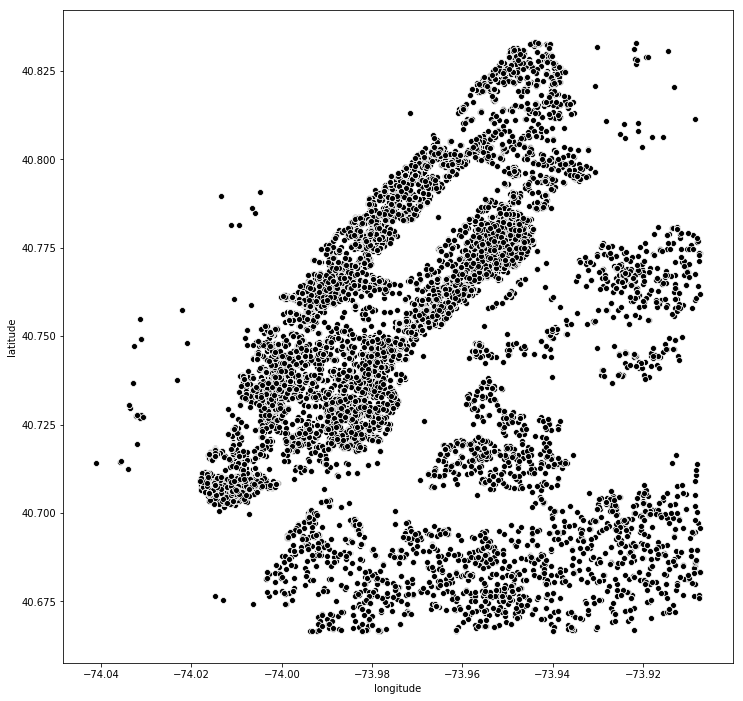

In [61]:
coordPlot = plt.figure(figsize=(12,12)).gca()
sns.scatterplot(x = 'longitude', \
                y = 'latitude', \
                color = 'black',
                data = train_df_pd)

There is a rough outline of the geography of NYC. Although only Manhattan, Brooklyn, and some of Queens is clearly visible. Almost all of Bronx and Staten island are left out of the dataset.

## 3.2 Plot Coordinates, Color by Interest

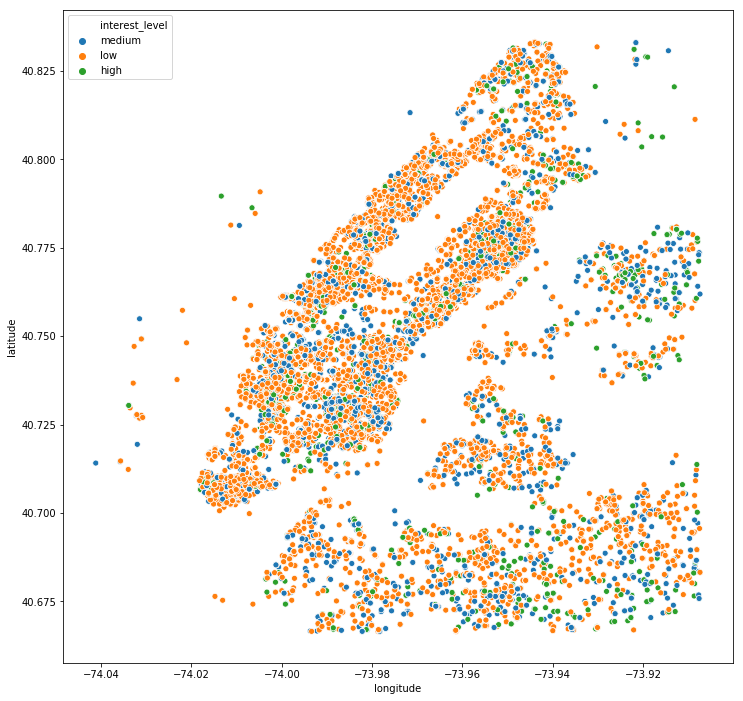

In [55]:
coordPlot = plt.figure(figsize=(12,12)).gca()
sns.scatterplot(x = 'longitude', \
                  y = 'latitude', \
                 hue = 'interest_level',
                 data = train_df_pd)

## 3.3 Separate Plots for Each Class

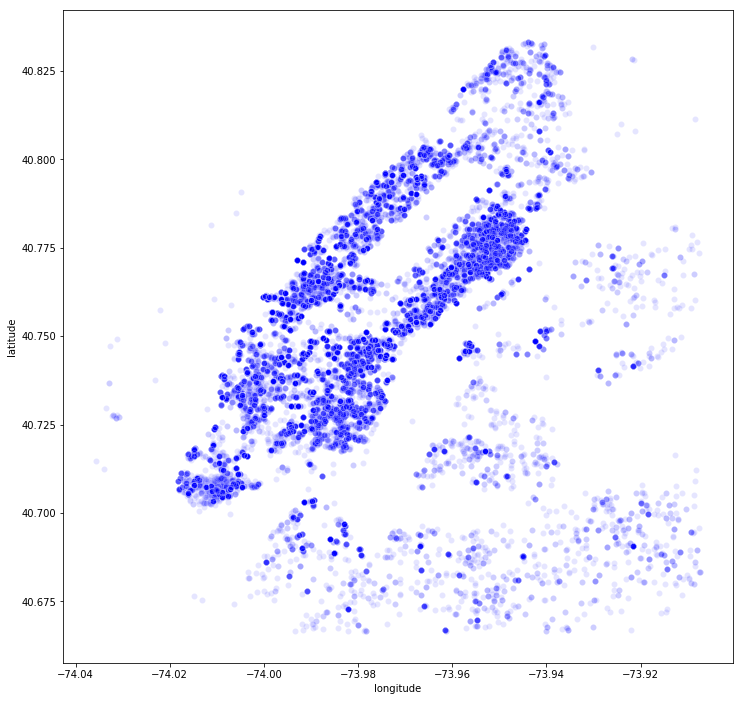

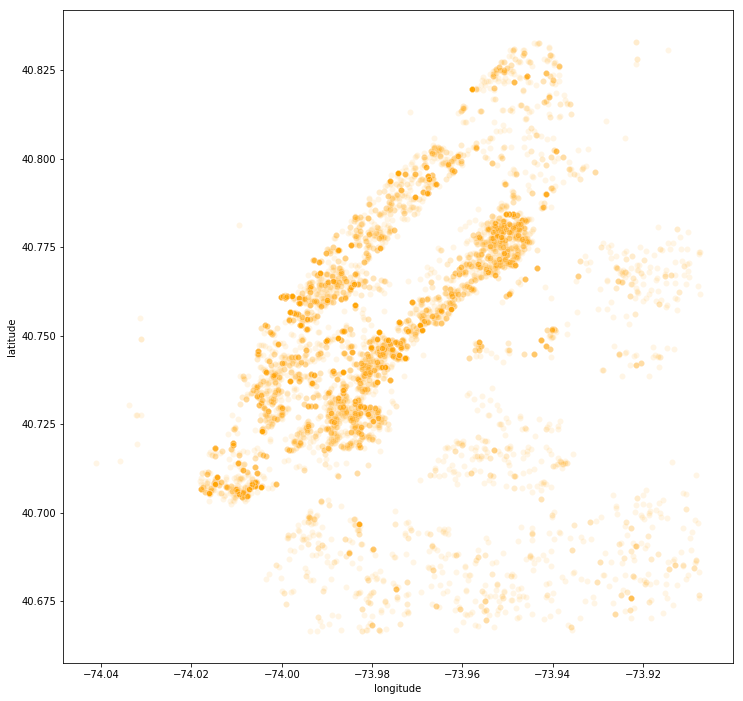

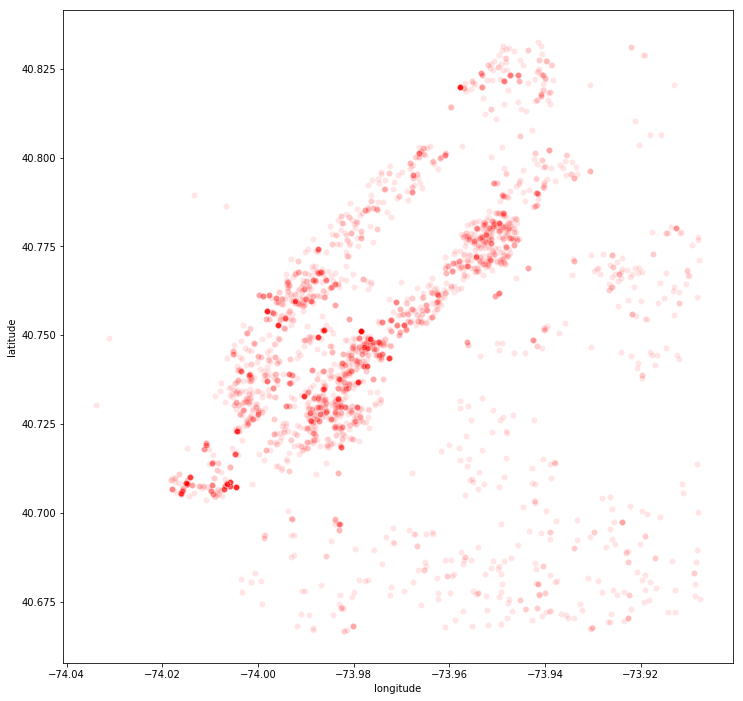

In [64]:
plt.subplots(figsize = (12, 12))
sns.scatterplot(train_df_pd.longitude[train_df_pd.interest_level == 'low'],
          train_df_pd.latitude[train_df_pd.interest_level == 'low'],
          color='blue',
          alpha=0.1,
            legend = False)
plt.subplots(figsize = (12, 12))
sns.scatterplot(train_df_pd.longitude[train_df_pd.interest_level == 'medium'],
          train_df_pd.latitude[train_df_pd.interest_level == 'medium'],
          color='orange',
          alpha=0.1,
            legend = False)
plt.subplots(figsize = (12, 12))
sns.scatterplot(train_df_pd.longitude[train_df_pd.interest_level == 'high'],
          train_df_pd.latitude[train_df_pd.interest_level == 'high'],
          color='red',
          alpha=0.1,
            legend = False)

# 4 Feature Engineering




    i)index interest_level to have response variable of integers 1, 2, and 3

    ii)bucketize latitude
    
    iii)bucketize longitude
    
    iv)vectorize bucketed long and lat together
    
    v)get df of just: indexed interest level, vectorized and bucketed long and lat

### 4.1 Index interest_level(reponse)

In [65]:
#Instantiate indexer
rental_df = train_df.select('latitude', 'longitude', 'interest_level')

indexer = StringIndexer(inputCol = 'interest_level', outputCol = 'interest_level_index')

rental_df = indexer.fit(rental_df).transform(rental_df).drop('interest_level')

rental_df.show()

+--------+---------+--------------------+
|latitude|longitude|interest_level_index|
+--------+---------+--------------------+
| 40.7145| -73.9425|                 1.0|
| 40.7947| -73.9667|                 0.0|
| 40.7388| -74.0018|                 2.0|
| 40.7539| -73.9677|                 0.0|
| 40.8241| -73.9493|                 0.0|
| 40.7429| -74.0028|                 1.0|
| 40.8012|  -73.966|                 0.0|
| 40.7427| -73.9957|                 0.0|
| 40.8234| -73.9457|                 1.0|
| 40.7278| -73.9808|                 0.0|
| 40.7769| -73.9467|                 0.0|
| 40.7512| -73.9784|                 0.0|
| 40.7488|  -73.977|                 2.0|
| 40.7707| -73.9817|                 0.0|
| 40.7584| -73.9648|                 0.0|
| 40.7439| -73.9743|                 1.0|
| 40.7305|  -73.983|                 0.0|
| 40.7512| -73.9784|                 0.0|
| 40.7999| -73.9638|                 0.0|
| 40.7328| -73.9799|                 0.0|
+--------+---------+--------------

## 4.2 Bucketize longitude and latitude

In [66]:
#lat is between 40.6665 and 40.8332
latSplits = numpy.arange(40.6664, 41.8333, .001)

bucketizer = Bucketizer(splits = latSplits, inputCol = 'latitude', outputCol = 'latBucketed')

rental_df = bucketizer.transform(rental_df)

In [67]:
#lat is between  -74.0412 and -73.9074
longSplits = numpy.arange(-74.0413, -73.9073, .001)

bucketizer = Bucketizer(splits = longSplits, inputCol = 'longitude', outputCol = 'longBucketed')

rental_df = bucketizer.transform(rental_df)

In [68]:
rental_df.show()

+--------+---------+--------------------+-----------+------------+
|latitude|longitude|interest_level_index|latBucketed|longBucketed|
+--------+---------+--------------------+-----------+------------+
| 40.7145| -73.9425|                 1.0|       48.0|        98.0|
| 40.7947| -73.9667|                 0.0|      128.0|        74.0|
| 40.7388| -74.0018|                 2.0|       72.0|        39.0|
| 40.7539| -73.9677|                 0.0|       87.0|        73.0|
| 40.8241| -73.9493|                 0.0|      157.0|        91.0|
| 40.7429| -74.0028|                 1.0|       76.0|        38.0|
| 40.8012|  -73.966|                 0.0|      134.0|        75.0|
| 40.7427| -73.9957|                 0.0|       76.0|        45.0|
| 40.8234| -73.9457|                 1.0|      157.0|        95.0|
| 40.7278| -73.9808|                 0.0|       61.0|        60.0|
| 40.7769| -73.9467|                 0.0|      110.0|        94.0|
| 40.7512| -73.9784|                 0.0|       84.0|        6

## 4.3 Assemble Features into a Vector

In [69]:
from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
rental_df = rental_df.withColumn("id", monotonically_increasing_id())

#Create('assemble') a vector of longitude and latitude to feed into our model as
# a single predictor variable
assembler = VectorAssembler(
    inputCols = ['latBucketed', 'longBucketed'],
    outputCol = 'featuresVec')

#Run our df through the assembler
rental_df = assembler.transform(rental_df)



rental_df.show(10)

+--------+---------+--------------------+-----------+------------+---+------------+
|latitude|longitude|interest_level_index|latBucketed|longBucketed| id| featuresVec|
+--------+---------+--------------------+-----------+------------+---+------------+
| 40.7145| -73.9425|                 1.0|       48.0|        98.0|  0| [48.0,98.0]|
| 40.7947| -73.9667|                 0.0|      128.0|        74.0|  1|[128.0,74.0]|
| 40.7388| -74.0018|                 2.0|       72.0|        39.0|  2| [72.0,39.0]|
| 40.7539| -73.9677|                 0.0|       87.0|        73.0|  3| [87.0,73.0]|
| 40.8241| -73.9493|                 0.0|      157.0|        91.0|  4|[157.0,91.0]|
| 40.7429| -74.0028|                 1.0|       76.0|        38.0|  5| [76.0,38.0]|
| 40.8012|  -73.966|                 0.0|      134.0|        75.0|  6|[134.0,75.0]|
| 40.7427| -73.9957|                 0.0|       76.0|        45.0|  7| [76.0,45.0]|
| 40.8234| -73.9457|                 1.0|      157.0|        95.0|  8|[157.0

Need to turn 'interest_level' into a numerical column

0 = low

1 = medium

2 = high

In [72]:
rental_df.show(5)

+--------+---------+--------------------+-----------+------------+---+------------+
|latitude|longitude|interest_level_index|latBucketed|longBucketed| id| featuresVec|
+--------+---------+--------------------+-----------+------------+---+------------+
| 40.7145| -73.9425|                 1.0|       48.0|        98.0|  0| [48.0,98.0]|
| 40.7947| -73.9667|                 0.0|      128.0|        74.0|  1|[128.0,74.0]|
| 40.7388| -74.0018|                 2.0|       72.0|        39.0|  2| [72.0,39.0]|
| 40.7539| -73.9677|                 0.0|       87.0|        73.0|  3| [87.0,73.0]|
| 40.8241| -73.9493|                 0.0|      157.0|        91.0|  4|[157.0,91.0]|
+--------+---------+--------------------+-----------+------------+---+------------+
only showing top 5 rows



# 5 K-Means Clustering

## 5.1 Optimum number of clusters

In [126]:
cost = np.zeros(30)
for k in range(2,30):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("featuresVec")
    model = kmeans.fit(rentalFinal_df.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(rentalFinal_df)



Text(0,0.5,'cost')

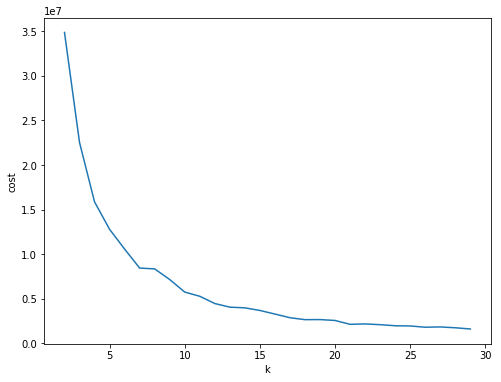

In [153]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,30),cost[2:30])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Lets pick k of 10. Seems like the main inflection point.

## 5.2 Clustering

Fit KMeans model on our data and print the cluster centers.

In [115]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('featuresVec')
model = kmeans.fit(rental_df)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[99.37634409 52.23655914]
[42.19853259 32.15925766]
[71.01565094 40.4159355 ]
[136.81203487  80.857963  ]
[17.94275362 63.14202899]
[110.1299041   91.94129613]
[ 29.08433735 104.66772353]
[92.27597873 81.08941518]
[80.88009592 62.29202093]
[60.29075472 55.89264151]


Now use the model we just fitted to assign clusters to each observation.

In [117]:
#Assign clusters to each point
transformed = model.transform(rental_df).select('prediction', 'id')

#Join predicitons with original data
transformed = transformed.join(rental_df, 'id')
transformed = transformed.select('id', 'prediction', 'latitude', 'longitude')
transformed.show()

+----+----------+--------+---------+
|  id|prediction|latitude|longitude|
+----+----------+--------+---------+
|  26|         5| 40.7728| -73.9502|
|  29|         5| 40.7716| -73.9506|
| 474|         1| 40.7061| -74.0111|
| 964|         8| 40.7482| -73.9786|
|1677|         2| 40.7297|  -74.004|
|1697|         9| 40.7349| -73.9863|
|1806|         1| 40.7162| -74.0155|
|1950|         3|  40.797| -73.9625|
|2040|         9| 40.7274| -73.9807|
|2214|         5| 40.7866| -73.9512|
|2250|         5| 40.7687| -73.9292|
|2453|         9| 40.7259| -73.9899|
|2509|         5| 40.7703| -73.9519|
|2529|         0|  40.761|  -73.999|
|2927|         8| 40.7466| -73.9779|
|3091|         9|  40.731| -73.9786|
|3506|         2|  40.748| -73.9998|
|3764|         9| 40.7364| -73.9809|
|4590|         8| 40.7491| -73.9789|
|4823|         7| 40.7481| -73.9564|
+----+----------+--------+---------+
only showing top 20 rows



## 5.3 Plotting clusters

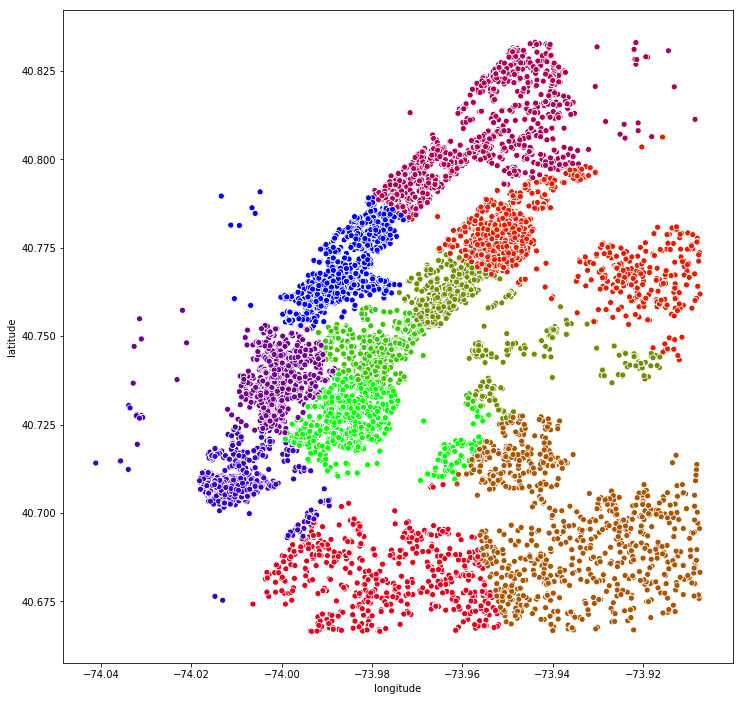

In [118]:
#Convert to pandas df for plotting
preds_kmeans_pddf = transformed.toPandas()

#Plot clusters by color along long/lat axes
coordPlot = plt.figure(figsize=(12,12)).gca()
sns.scatterplot(x = 'longitude',
                y = 'latitude',
                hue = 'prediction',
                palette = 'brg',
                data = preds_kmeans_pddf,
                legend = False)

# 6 GMM Clustering

In [120]:
from pyspark.ml.clustering import GaussianMixture

k = 10
gmm = GaussianMixture().setK(k).setSeed(1).setFeaturesCol("featuresVec")
gmm_model = gmm.fit(rental_df)



In [121]:
gmmtransformed = gmm_model.transform(rental_df).select('prediction', 'id')
rows = gmmtransformed.collect()
print(rows[:3])

[Row(prediction=1, id=0), Row(prediction=5, id=1), Row(prediction=4, id=2)]


In [122]:
gmmtransformed = gmmtransformed.join(rental_df, 'id')
gmmtransformed = gmmtransformed.select('id', 'prediction', 'latitude', 'longitude')
gmmtransformed.show()

+----+----------+--------+---------+
|  id|prediction|latitude|longitude|
+----+----------+--------+---------+
|  26|         2| 40.7728| -73.9502|
|  29|         2| 40.7716| -73.9506|
| 474|         8| 40.7061| -74.0111|
| 964|         6| 40.7482| -73.9786|
|1677|         4| 40.7297|  -74.004|
|1697|         7| 40.7349| -73.9863|
|1806|         4| 40.7162| -74.0155|
|1950|         5|  40.797| -73.9625|
|2040|         7| 40.7274| -73.9807|
|2214|         2| 40.7866| -73.9512|
|2250|         1| 40.7687| -73.9292|
|2453|         7| 40.7259| -73.9899|
|2509|         2| 40.7703| -73.9519|
|2529|         4|  40.761|  -73.999|
|2927|         6| 40.7466| -73.9779|
|3091|         7|  40.731| -73.9786|
|3506|         4|  40.748| -73.9998|
|3764|         7| 40.7364| -73.9809|
|4590|         6| 40.7491| -73.9789|
|4823|         1| 40.7481| -73.9564|
+----+----------+--------+---------+
only showing top 20 rows



In [123]:
gmmtransformed.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 4832|
|         6| 3002|
|         3| 3485|
|         5| 6132|
|         9| 3414|
|         4|11278|
|         8| 3347|
|         7| 4914|
|         2| 5317|
|         0| 3631|
+----------+-----+



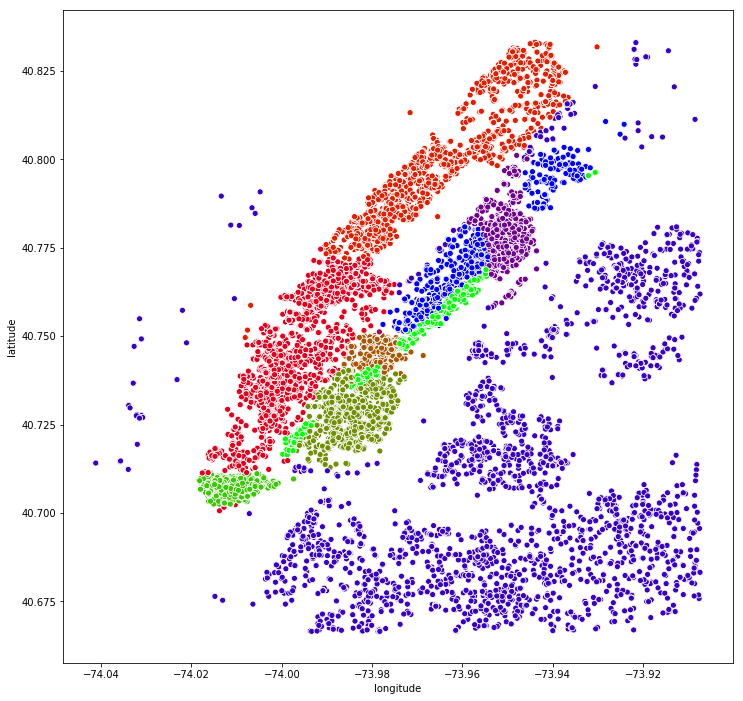

In [125]:
#Convert to pandas df for plotting
preds_gmm_pddf = gmmtransformed.toPandas()

#Plot clusters by color along long/lat axes
coordPlot = plt.figure(figsize=(12,12)).gca()
sns.scatterplot(x = 'longitude',
                y = 'latitude',
                hue = 'prediction',
                palette = 'brg',
                data = preds_gmm_pddf,
                legend = False)

# 7 Predicting

## 7.1 Splitting the data

In [73]:
#SPLIT TRAIN DATA BUT REALLY WE SHOULD TEST ON TEST DATA

trainingSet, testSet = rental_df.randomSplit([.8, .2])

In [127]:
#Weird, it seems like both test and train data is ordered in ascending order
trainingSet.show(5)

+--------+---------+--------------------+-----------+------------+-----+-----------+
|latitude|longitude|interest_level_index|latBucketed|longBucketed|   id|featuresVec|
+--------+---------+--------------------+-----------+------------+-----+-----------+
| 40.6665| -73.9787|                 0.0|        0.0|        62.0|14502| [0.0,62.0]|
| 40.6665| -73.9783|                 0.0|        0.0|        62.0|10364| [0.0,62.0]|
| 40.6665| -73.9783|                 0.0|        0.0|        62.0|17676| [0.0,62.0]|
| 40.6665| -73.9614|                 0.0|        0.0|        79.0|22491| [0.0,79.0]|
| 40.6666| -73.9821|                 0.0|        0.0|        59.0|19371| [0.0,59.0]|
+--------+---------+--------------------+-----------+------------+-----+-----------+
only showing top 5 rows



## 7.2 Performance Metrics

Create log-loss function to determine log-loss

In [131]:
from numpy import log

def log_loss(results_transformed, lables = "label", probability = "probability"):    
    labs_and_preds = results_transformed[lables, probability]
    
    return - labs_and_preds\
                .rdd\
                .map(lambda x: log(x[1][x[0]]))\
                .reduce(lambda x,y: x + y) / labs_and_preds.count()

>pseudo-code: 